## Imports

In [1]:
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import numpy as np
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

## 0. Carregar e Preprocessar o DataSet MNIST

In [2]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# 1. Tratar as Imagens

## 1.1 Normalizar as Imagens para o Intervalo [0, 1]

#### CÓDIGO:

In [3]:
train_images = train_images / 255.0
test_images = test_images / 255.0

#### EXPLICAÇÕES:

##### **Normalização das Imagens**

Antes de treinar um modelo de rede neural, é comum normalizar as imagens para garantir que os valores dos pixels estejam dentro de uma faixa padrão. Isso ajuda a melhorar a eficiência e a convergência do treinamento. A normalização é feita dividindo os valores dos pixels por 255, que é o valor máximo para um pixel em uma imagem com 8 bits.

A divisão por `255.0` normaliza os valores para o intervalo [0, 1]. Assim, os valores de pixel são ajustados para uma faixa mais uniforme, facilitando o treinamento. Por exemplo:

- Valor original do pixel: 128
- Após normalização: 128 / 255.0 ≈ 0.502

**Obs:** A conversão explícita dos valores para `float32` com `astype('float32')` pode ser realizada para garantir que os dados estejam no formato adequado para o processamento em alguns casos específicos. No entanto, essa conversão pode ser desnecessária, pois a divisão por `255.0` já converte os valores para o tipo de dado de ponto flutuante.

Essa normalização ajusta os valores dos pixels para um formato que o modelo pode processar de maneira mais eficiente e estável.


## 1.2 Converter Rótulos para One-hot Encoding
- **Observação**: Esta etapa é opcional se a `Função de Perda` for **`sparse_categorical_crossentropy`**, que aceita rótulos diretamente como números inteiros.

#### CÓDIGO:

In [ ]:
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

#### EXPLICAÇÕES:

##### **One-Hot Encoding para Classificação**

Em problemas de classificação, os rótulos das classes (ou labels) geralmente são representados como números inteiros, onde cada número corresponde a uma classe específica. No entanto, os modelos de machine learning, especialmente redes neurais, funcionam melhor quando esses rótulos são representados de maneira binária. É aqui que entra o **one-hot encoding**.

##### **O que é One-Hot Encoding?**

**One-hot encoding** é uma técnica de codificação que transforma uma categoria (classe) em um vetor binário. Esse vetor tem o mesmo comprimento que o número de classes totais e contém um único valor `1` no índice correspondente à classe correta, enquanto todos os outros valores são `0`.

Por exemplo, se tivermos três classes possíveis (0, 1 e 2):
- A classe `0` seria representada como `[1, 0, 0]`.
- A classe `1` seria representada como `[0, 1, 0]`.
- A classe `2` seria representada como `[0, 0, 1]`.

##### **Por que usar One-Hot Encoding?**

- **Facilita o treinamento**: Modelos como redes neurais precisam de rótulos em um formato que possa ser diretamente comparado com as saídas do modelo, que normalmente também são vetores de probabilidades. One-hot encoding facilita essa comparação.
- **Evita hierarquias implícitas**: Sem one-hot encoding, se as classes fossem representadas por números inteiros (como 0, 1, 2...), o modelo poderia interpretar erroneamente que há uma ordem ou hierarquia entre as classes. One-hot encoding elimina essa ambiguidade, tratando todas as classes de forma equitativa.

##### **Implementação em TensorFlow**

Em TensorFlow, a função `tf.keras.utils.to_categorical` é utilizada para realizar a conversão dos rótulos em vetores binários (one-hot encoded). Se você tiver 10 classes diferentes, cada rótulo será transformado em um vetor de tamanho 10, onde apenas o índice correspondente à classe correta terá o valor `1`, e todos os outros índices terão o valor `0`.

Por exemplo, se uma imagem pertence à classe `3` e há 10 classes no total, após a aplicação de one-hot encoding, o rótulo original `3` será convertido para `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`.

Esta representação é fundamental para a correta operação do modelo, especialmente ao calcular a perda e ajustar os pesos durante o treinamento.


# 2. Definir a Arquitetura do Modelo

#### CÓDIGO API: Sequential
- Modelo Sequencial: Este modelo utiliza a API sequencial do Keras para construir uma arquitetura de rede neural convolucional com várias camadas. Ele não é ramificado, mas implementa técnicas para melhorar o desempenho e evitar overfitting, como Dropout. A seguir, a descrição detalhada do modelo:


In [4]:
model = models.Sequential([
    Input(shape=(28, 28, 1)),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),

    layers.Dense(10, activation='softmax')
])

#### EXPLICAÇÕES:

##### **Arquitetura do Modelo**

Este modelo é uma rede neural convolucional (CNN) avançada, projetada para a tarefa de classificação de imagens em um conjunto de dados de 10 classes. Ele foi desenvolvido com o objetivo de capturar e aprender padrões complexos nas imagens de entrada, usando uma combinação de camadas convolucionais, de pooling, normalização, regularização e camadas densas. A seguir, descrevemos em detalhes cada componente da arquitetura, os parâmetros utilizados e o impacto de cada escolha no desempenho do modelo.

---

##### 1. **Camada de Entrada**
- **`Input(shape=(28, 28, 1))`**:
  - **Função**: Define a forma dos dados que serão alimentados na rede. Este é o ponto de partida onde as imagens são inseridas no modelo para processamento.
  - **Parâmetros**:
    - **`shape=(28, 28, 1)`**: Especifica que cada imagem tem 28 pixels de altura, 28 pixels de largura e 1 canal (escala de cinza).
  - **Detalhe**: Esta camada não realiza processamento, mas informa à rede sobre o formato dos dados de entrada. A configuração correta do `shape` é crucial para garantir que as operações subsequentes sejam aplicadas corretamente.

---

##### 2. **Camadas Convolucionais, de Pooling e BatchNormalization**
Essas camadas formam o núcleo da arquitetura convolucional, responsáveis por extrair e processar características das imagens de entrada. Cada camada convolucional aplica filtros para detectar padrões específicos, como bordas, texturas ou formas. Em seguida, as camadas de pooling reduzem a dimensionalidade dos dados, enquanto a normalização em lote (`BatchNormalization`) estabiliza e acelera o treinamento.

###### 2.1. **Primeira Ramificação**
- **`Conv2D(32, (3,3), activation='relu', padding='same')`**:
  - **Função**: Aplica uma operação de convolução 2D para detectar características como bordas e texturas.
  - **Parâmetros**:
    - **`32`**: Número de filtros que detectam diferentes padrões.
    - **`(3,3)`**: Tamanho dos filtros, ideal para captar detalhes locais.
    - **`activation='relu'`**: Introduz não-linearidade ao modelo, transformando valores negativos em zero.
    - **`padding='same'`**: Mantém as dimensões espaciais da saída iguais às da entrada.

- **`BatchNormalization()`**:
  - **Função**: Normaliza as ativações da camada anterior, estabilizando o treinamento.
  - **Detalhe**: Reduz a necessidade de ajustes manuais nos hiperparâmetros e acelera o treinamento.

- **`MaxPooling2D((2,2))`**:
  - **Função**: Reduz a dimensionalidade espacial, preservando as características mais importantes.
  - **Parâmetros**:
    - **`(2,2)`**: Tamanho da janela de pooling, reduzindo a altura e largura pela metade.

- **`Dropout(0.35)`**:
  - **Função**: Desativa aleatoriamente 35% dos neurônios durante o treinamento para evitar overfitting.

###### 2.2. **Segunda Ramificação**
- **`Conv2D(32, (5,5), activation='relu', padding='same')`**:
  - **Função**: Semelhante à primeira ramificação, mas com filtros maiores (5x5), captando padrões em escalas maiores.

- **Outras camadas**: Seguem o mesmo padrão da primeira ramificação, mas ajustadas para diferentes escalas.

---

##### 3. **Camada de Concatenação**
- **`layers.concatenate([rami1_drop2, rami2_drop2])`**:
  - **Função**: Junta as saídas das duas ramificações, combinando diferentes representações aprendidas.

---

##### 4. **Global Average Pooling**
- **`GlobalAveragePooling2D()`**:
  - **Função**: Calcula a média de cada mapa de características ao longo de sua dimensão espacial.
  - **Detalhe**: Reduz o número de parâmetros, diminuindo o risco de overfitting.

---

##### 5. **Camadas Densas**
As camadas densas combinam as características extraídas e aprendem a tomar decisões de classificação. 

- **`Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))`**:
  - **Função**: Aplica uma transformação linear seguida de ativação ReLU.
  - **Parâmetros**:
    - **`256`**: Número de neurônios.
    - **`activation='relu'`**: Introduz não-linearidade.
    - **`kernel_regularizer=regularizers.l2(0.001)`**: Penaliza grandes valores de peso para evitar overfitting.

- **`Dropout(0.5)`**: Desativa aleatoriamente 50% dos neurônios para maior regularização.

---

##### 6. **Camada de Saída**
- **`Dense(10, activation='softmax')`**:
  - **Função**: Transforma as saídas em probabilidades para classificação nas 10 classes.
  - **Detalhe**: A função `softmax` garante que a soma das probabilidades seja igual a 1, permitindo interpretar a saída como probabilidades de cada classe.

---

##### **Resumo da Arquitetura**
1. Camada de entrada define o formato dos dados.
2. Ramificações convolucionais extraem características em diferentes escalas.
3. Concatenação combina representações aprendidas.
4. Pooling global reduz a dimensionalidade.
5. Camadas densas sintetizam informações para classificação.
6. Camada de saída fornece probabilidades das classes.


## 2.1 Exibir Resumo da Arquitetura

#### CÓDIGO:

In [5]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 3, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 389,130 (1.48 MB)

 Trainable params: 389,130 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

#### EXPLICAÇÕES:

##### **Resumo da Arquitetura do Modelo**

O comando `model.summary()` exibe um resumo detalhado da arquitetura do modelo, permitindo uma análise clara de sua estrutura e complexidade. Abaixo estão os elementos principais exibidos no resumo:

---

1. **Tipo de Camada e Nome**:
   - Cada camada do modelo é listada com seu tipo (como `Conv2D`, `MaxPooling2D`, `Flatten`, `Dense`) e o nome atribuído automaticamente ou definido pelo usuário.
   - Exemplo: A camada `conv2d` é do tipo `Conv2D`.

2. **Forma de Saída**:
   - A coluna "Output Shape" descreve o formato da saída de cada camada. Esse formato é exibido como uma tupla contendo:
     - Número de amostras (geralmente `None`, pois não está definido no momento da criação do modelo).
     - Altura e largura (dimensões espaciais das saídas).
     - Número de canais (para camadas convolucionais).
   - Exemplo: `(None, 28, 28, 32)` significa que a saída dessa camada possui 32 canais e dimensões espaciais de 28x28.

3. **Número de Parâmetros**:
   - A coluna "Param #" mostra o número total de parâmetros treináveis e não treináveis em cada camada:
     - **Camadas Convolucionais**: Parâmetros incluem pesos dos filtros e vieses. Por exemplo:
       - Para `conv2d` com 32 filtros de tamanho 3x3, o cálculo é `(3*3*1*32) + 32 = 320`.
     - **Camadas Densas**: Parâmetros incluem pesos conectando todos os neurônios e vieses.

4. **Parâmetros Totais**:
   - **Total params**: Soma de todos os parâmetros do modelo.
   - **Trainable params**: Parâmetros ajustáveis durante o treinamento.
   - **Non-trainable params**: Parâmetros que não são atualizados durante o treinamento (não presentes neste modelo).

---

##### **Tabela Resumida do Modelo**

| **Camada (tipo)**          | **Forma de Saída**       | **Param #**    |
|----------------------------|--------------------------|----------------|
| `conv2d` (Conv2D)          | (None, 28, 28, 32)      | 320            |
| `max_pooling2d` (MaxPooling2D) | (None, 14, 14, 32)      | 0              |
| `conv2d_1` (Conv2D)        | (None, 14, 14, 64)      | 18,496         |
| `max_pooling2d_1` (MaxPooling2D) | (None, 7, 7, 64)        | 0              |
| `conv2d_2` (Conv2D)        | (None, 7, 7, 128)       | 73,856         |
| `max_pooling2d_2` (MaxPooling2D) | (None, 3, 3, 128)       | 0              |
| `conv2d_3` (Conv2D)        | (None, 3, 3, 128)       | 147,584        |
| `flatten` (Flatten)        | (None, 1152)            | 0              |
| `dense` (Dense)            | (None, 128)             | 147,584        |
| `dropout` (Dropout)        | (None, 128)             | 0              |
| `dense_1` (Dense)          | (None, 10)              | 1,290          |

---

##### **Resumo de Parâmetros**
- **Total params**: 389,130 (1.48 MB).
- **Trainable params**: 389,130 (1.48 MB).
- **Non-trainable params**: 0 (0.00 B).

---

Este resumo fornece uma visão geral clara da arquitetura do modelo, incluindo a estrutura das camadas, dimensões intermediárias e a quantidade de parâmetros ajustáveis durante o treinamento.



# 3. Compilar o Modelo

#### CÓDIGO:

In [6]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',     
              metrics=['accuracy'])

#### EXPLICAÇÕES:

##### **Compilação do Modelo**

O comando `model.compile()` é utilizado para configurar o modelo antes do treinamento. Durante a compilação, são definidos o otimizador, a função de perda e as métricas a serem avaliadas. Aqui estão os detalhes de cada parâmetro:

1. **Otimizador**:
   - **`optimizer='adam'`**: O otimizador é um algoritmo responsável por ajustar os pesos da rede neural durante o treinamento. O Adam (Adaptive Moment Estimation) é um dos otimizadores mais populares e eficazes, combinando as vantagens do Gradient Descent com momentos e a otimização adaptativa dos parâmetros. Ele adapta as taxas de aprendizado para cada parâmetro com base em momentos de gradientes e no histórico das atualizações, o que o torna adequado para uma ampla variedade de problemas de treinamento.

2. **Função de Perda**:
   - **`loss='categorical_crossentropy'`**: A função de perda mede a discrepância entre as previsões do modelo e os rótulos verdadeiros. No caso de problemas de classificação multiclasse, como o MNIST, a entropia cruzada categórica é amplamente utilizada. Ela calcula a diferença entre a distribuição de probabilidade prevista pelo modelo (saída da função softmax) e a distribuição real dos rótulos. A minimização dessa função de perda durante o treinamento ajuda o modelo a aprender as classes corretas para cada exemplo.

   - **`loss='sparse_categorical_crossentropy'`**: Essa função é semelhante à `categorical_crossentropy`, mas difere na forma como os rótulos são processados. Enquanto `categorical_crossentropy` requer que os rótulos estejam no formato one-hot encoded (uma matriz onde a classe correta é representada por 1 e as demais por 0), `sparse_categorical_crossentropy` aceita rótulos como inteiros simples, representando diretamente a classe correta. Essa função pode ser mais conveniente quando os dados de rótulos não estão em formato one-hot, simplificando o pipeline de pré-processamento.

3. **Métricas**:
   - **`metrics=['accuracy']`**: As métricas são usadas para monitorar o desempenho do modelo durante o treinamento e a avaliação. A acurácia é uma métrica comum que mede a proporção de previsões corretas em relação ao total de previsões feitas. Ao incluir `accuracy` nas métricas, você poderá acompanhar como a precisão do modelo melhora (ou não) a cada época de treinamento. Esta métrica é particularmente útil para problemas de classificação, fornecendo uma visão clara do desempenho do modelo.

A compilação é um passo crucial que prepara o modelo para o processo de treinamento, garantindo que ele utilize o otimizador e a função de perda apropriados para o problema em questão. Essa configuração é essencial para que o processo de otimização funcione corretamente, orientando o modelo na direção de menor erro possível e, consequentemente, melhor desempenho.

#### EXPLICAÇÕES EXTRAS: (Otimizadores)

##### **Otimizadores em Redes Neurais**

Escolher o otimizador adequado é crucial para o treinamento eficaz de redes neurais. Os otimizadores ajustam os pesos da rede para minimizar a função de perda, e diferentes otimizadores têm características distintas que podem influenciar a eficiência e o desempenho do treinamento.

##### **Tipos de Otimizadores:**

1. **Gradient Descent (GD)**
   - **Batch Gradient Descent**: Calcula o gradiente da função de perda usando o conjunto de dados completo para cada atualização de peso. Pode ser lento e consumir muita memória para grandes conjuntos de dados.

---

2. **Stochastic Gradient Descent (SGD)**
   - **SGD**: Atualiza os pesos com base em um único exemplo de treinamento por vez. Isso torna o treinamento mais rápido e menos oneroso em termos de memória, mas pode ser mais ruidoso e menos estável. É útil quando se lida com grandes conjuntos de dados.

---

3. **Mini-Batch Gradient Descent**
   - **Mini-Batch SGD**: Atualiza os pesos com base em um único exemplo de treinamento por vez. Isso faz com que o treinamento seja mais rápido e menos oneroso em termos de memória, mas pode ser mais ruidoso e menos estável. É o método mais comum utilizado na prática.

---

4. **Momentum**
   - **Momentum**: Adiciona um termo de "momentum" à atualização dos pesos, o que ajuda a acelerar o treinamento e a suavizar as oscilações. O momento é um parâmetro que acumula o gradiente das iterações anteriores.

---

5. **Nesterov Accelerated Gradient (NAG)**
   - **NAG**: Uma variante do Momentum que realiza uma "olhada à frente" no gradiente para melhorar a convergência. Isso pode proporcionar uma convergência mais rápida e precisa.

---

6. **Adagrad**
   - **Adagrad**: Ajusta a taxa de aprendizado para cada parâmetro com base na frequência das atualizações. Isso pode ajudar a lidar com parâmetros que são atualizados com menos frequência, mas pode levar a uma taxa de aprendizado que decai rapidamente.

---

7. **RMSprop**
   - **RMSprop**: Modifica o Adagrad para reduzir o problema do decaimento rápido da taxa de aprendizado, ajustando a taxa de aprendizado com base em uma média móvel das magnitudes recentes dos gradientes. É eficaz para problemas de treinamento com dados ruidosos ou modelos com muitos parâmetros.

---

8. **Adam (Adaptive Moment Estimation)**
   - **Adam**: Combina as ideias de Momentum e RMSprop. Utiliza estimativas de médias móveis dos gradientes e dos quadrados dos gradientes para adaptar a taxa de aprendizado para cada parâmetro. É amplamente utilizado devido à sua eficiência e à necessidade reduzida de ajuste de hiperparâmetros.

---

9. **AdaMax**
   - **AdaMax**: Uma variante do Adam baseada na norma infinita. Pode ser útil em cenários específicos, oferecendo uma abordagem diferente para a adaptação da taxa de aprendizado.

---

10. **Nadam**
    - **Nadam**: Combina Adam e NAG, fornecendo um método de otimização que incorpora tanto o momentum quanto o ajuste adaptativo da taxa de aprendizado.

---

##### **Como Escolher o Otimizador**

1. **Natureza do Problema**:
   - **Para problemas com grandes conjuntos de dados ou redes neurais profundas**, o Adam pode ser mais eficaz devido à sua capacidade de adaptar a taxa de aprendizado e acelerar a convergência.

2. **Tipo de Rede Neural**:
   - **Redes Neurais Convolucionais (CNNs)**: Adam é frequentemente utilizado devido ao seu desempenho superior e capacidade de lidar com gradientes em redes profundas.
   - **Redes Neurais Recorrentes (RNNs)**: Adam ou RMSprop são frequentemente preferidos devido à natureza do treinamento das RNNs e suas propriedades.

3. **Recursos Computacionais**:
   - **Memória e Computação**: O SGD pode ser preferível se a memória e a capacidade computacional são limitadas.

4. **Experiência e Experimentação**:
   - **Experiência e Ajuste**: Frequentemente, é uma boa prática experimentar diferentes otimizadores e ajustar hiperparâmetros para encontrar o que melhor funciona para o problema específico.

##### **Resumo**

A escolha do otimizador pode impactar significativamente o treinamento e a performance do modelo. Enquanto o SGD é simples e eficiente, o Adam geralmente oferece uma convergência mais rápida e melhor desempenho para uma ampla gama de problemas. A escolha deve ser baseada nas características do problema, do modelo e dos recursos disponíveis.


#### EXPLICAÇÕES EXTRAS: (Função de Perda)

##### 1. **O Que é Função de Perda?**

A função de perda é a fórmula que mede o quão bem o modelo está performando durante o treinamento, comparando as previsões do modelo com os valores reais (rótulos). Ela calcula uma diferença, erro ou "perda", que o modelo tenta minimizar. Durante o treinamento, o objetivo do modelo é ajustar os pesos e os parâmetros para minimizar essa perda, o que, em teoria, melhorará a precisão do modelo.

##### 2. **Tipos de Função de Perda**

Os tipos de funções de perda variam com base no tipo de problema que você está tentando resolver, como classificação binária, classificação multiclasse ou regressão.

- **Classificação Binária**:
  - **Binary Cross-Entropy (binary_crossentropy)**:
    - Utilizada para problemas de classificação com duas classes. Mede a perda entre as probabilidades previstas pelo modelo e os rótulos binários (0 ou 1). 
    - É especialmente útil para modelos que utilizam a função de ativação `sigmoid` na camada de saída.

---

- **Classificação Multiclasse**:
  - **Categorical Cross-Entropy (categorical_crossentropy)**:
    - Usada quando os rótulos são representados como vetores one-hot (vetores binários onde apenas uma posição é 1, representando a classe correta). 
    - Mede a perda entre as probabilidades previstas e os vetores one-hot. 
    - Ideal para modelos com a função de ativação `softmax` na camada de saída.

  - **Sparse Categorical Cross-Entropy (sparse_categorical_crossentropy)**:
    - Semelhante à `categorical_crossentropy`, mas lida com rótulos inteiros em vez de vetores one-hot. 
    - É útil quando os rótulos são representados como números inteiros, economizando memória e processamento.

---

- **Regressão**:
  - **Mean Squared Error (mean_squared_error)**:
    - Usada para problemas de regressão onde o objetivo é prever valores contínuos. 
    - Mede a média dos quadrados das diferenças entre os valores previstos e os valores reais. 
    - É sensível a outliers, pois o erro é elevado ao quadrado.

---

  - **Mean Absolute Error (mean_absolute_error)**:
    - Também utilizada em problemas de regressão, mas mede a média das diferenças absolutas entre os valores previstos e reais. 
    - É menos sensível a outliers comparado ao MSE.

---

##### 3. **Escolhendo a Função de Perda**

- **Classificação Binária**: Utilize `binary_crossentropy` para medir o erro entre as previsões de probabilidade e os rótulos binários.
- **Classificação Multiclasse**:
  - **Rótulos One-Hot**: Utilize `categorical_crossentropy` para comparar as probabilidades previstas com os vetores one-hot dos rótulos.
  - **Rótulos Inteiros**: Utilize `sparse_categorical_crossentropy` para lidar diretamente com rótulos inteiros.
- **Regressão**:
  - Use `mean_squared_error` se a precisão exata for importante e `mean_absolute_error` se a robustez a outliers for desejada.

##### **Resumo**

A função de perda é essencial para guiar o treinamento de modelos, pois indica o quanto o modelo está errando nas suas previsões. A escolha correta da função de perda é fundamental e deve corresponder ao tipo de problema e ao formato dos rótulos para garantir um treinamento eficaz e obter melhores resultados.


# 4. Treinar o Modelo

#### CÓDIGO:

In [8]:
history = model.fit(train_images, train_labels, 
                    epochs=10, 
                    batch_size=64, 
                    validation_split=0.1)

Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8407 - loss: 0.4833 - val_accuracy: 0.9865 - val_loss: 0.0419
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9823 - loss: 0.0614 - val_accuracy: 0.9905 - val_loss: 0.0301
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9873 - loss: 0.0422 - val_accuracy: 0.9905 - val_loss: 0.0341
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9896 - loss: 0.0328 - val_accuracy: 0.9907 - val_loss: 0.0320
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9924 - loss: 0.0265 - val_accuracy: 0.9930 - val_loss: 0.0292
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9939 - loss: 0.0208 - val_accuracy: 0.9923 - val_loss: 0.0272
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9955 - loss: 0.0141 - val_accuracy: 0.9925 - val_loss: 0.0280
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9967 - loss: 0.0123 - val_accuracy:

#### EXPLICAÇÕES:

##### **Treinamento do Modelo**

- **`history =`**:
   - `history` é uma variável que armazena o objeto retornado pelo método `fit()`. Esse objeto contém registros das métricas (como acurácia e perda) durante cada época de treinamento, tanto para o conjunto de treinamento quanto para o de validação. Ele é útil para analisar o desempenho do modelo após o treinamento.

- **`model.fit(...)`**:
   - O método `.fit()` realiza o treinamento do modelo, ajustando os pesos para minimizar a função de perda. Ele utiliza os dados de entrada (`train_images`) e os rótulos correspondentes (`train_labels`) para aprender os padrões e realizar previsões mais precisas. 

- **`train_images` e `train_labels`**:
   - `train_images`: Conjunto de imagens utilizadas como entrada para o treinamento.
   - `train_labels`: Conjunto de rótulos correspondentes às imagens, que servem como referência para o cálculo da perda e para guiar o treinamento.

- **`epochs=10`**:
   - Especifica o número de épocas de treinamento. Cada época corresponde a uma passagem completa por todo o conjunto de dados de treinamento. Aqui, o modelo será treinado por 10 épocas.

- **`batch_size=64`**:
   - Define o número de amostras processadas antes de atualizar os pesos do modelo. Neste caso, 64 imagens são processadas por vez. Isso ajuda a equilibrar o uso de memória e o desempenho do treinamento.

- **`validation_split=0.1`**:
   - Este parâmetro reserva 10% dos dados de treinamento para validação. Esses dados não são utilizados para ajustar os pesos, mas servem para avaliar o desempenho do modelo durante o treinamento. Isso é útil para monitorar se o modelo está generalizando bem.

---

##### **Métricas do Treinamento**

1. **`accuracy:`**
   - Mede a porcentagem de previsões corretas feitas pelo modelo em relação ao total de previsões durante o treinamento. Uma acurácia crescente indica que o modelo está aprendendo os padrões dos dados.

2. **`loss:`**
   - Representa a discrepância entre as previsões do modelo e os valores reais (rótulos). O objetivo do treinamento é minimizar essa métrica. Uma perda decrescente durante o treinamento indica que o modelo está melhorando.

3. **`Validation Accuracy (Acurácia de Validação):`**
   - Mede a porcentagem de previsões corretas feitas pelo modelo em relação aos dados de validação. Isso ajuda a verificar se o modelo está generalizando bem.

4. **`Validation Loss (Perda de Validação):`**
   - Mede a discrepância entre as previsões do modelo e os valores reais no conjunto de validação. Uma perda de validação decrescente indica boa generalização. Se a `val_loss` aumenta enquanto a perda de treinamento diminui, pode indicar overfitting.

---

##### **Interpretação das Métricas durante o Treinamento**

1. **`Fase Inicial (Épocas Iniciais):`**
   - **Accuracy e Loss:** A acurácia de treinamento pode ser baixa e a perda alta, pois o modelo está aprendendo os padrões iniciais dos dados.
   - **Validation Accuracy e Validation Loss:** Essas métricas podem flutuar mais devido à menor quantidade de dados de validação, mas devem ser próximas das métricas de treinamento.

2. **`Fase Intermediária:`**
   - **Accuracy e Loss:** A acurácia de treinamento deve aumentar e a perda de treinamento deve diminuir à medida que o modelo aprende.
   - **Validation Accuracy e Validation Loss:** Se essas métricas melhoram junto com as métricas de treinamento, o modelo está generalizando bem.

3. **`Fase Tardia:`**
   - **Overfitting:** Se a `accuracy` continua aumentando e a `loss` continua diminuindo, mas a `val_accuracy` se estabiliza ou piora e a `val_loss` começa a aumentar, isso indica overfitting. O modelo está memorizando os dados de treinamento, mas não está aprendendo a generalizar.
   - **Underfitting:** Se as métricas de treinamento e validação permanecem baixas, o modelo pode estar underfitting, ou seja, incapaz de capturar os padrões dos dados devido a um modelo muito simples ou dados insuficientes.

---

##### **Código Exemplo**

```python
history = model.fit(
    train_images,          # Dados de entrada para o treinamento
    train_labels,          # Rótulos correspondentes
    epochs=10,             # Número de épocas
    batch_size=64,         # Tamanho do batch
    validation_split=0.1   # 10% dos dados reservados para validação
)


## 4.1 Resumo da Arquitetura após Compilar e Treinar

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 3, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,167,392 (4.45 MB)

 Trainable params: 389,130 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 778,262 (2.97 MB)

## 4.2 Plotar Gráficos para Avaliar a Evolução do Treinamento

In [10]:
history_dict = history.history

history_df = pd.DataFrame(history_dict)

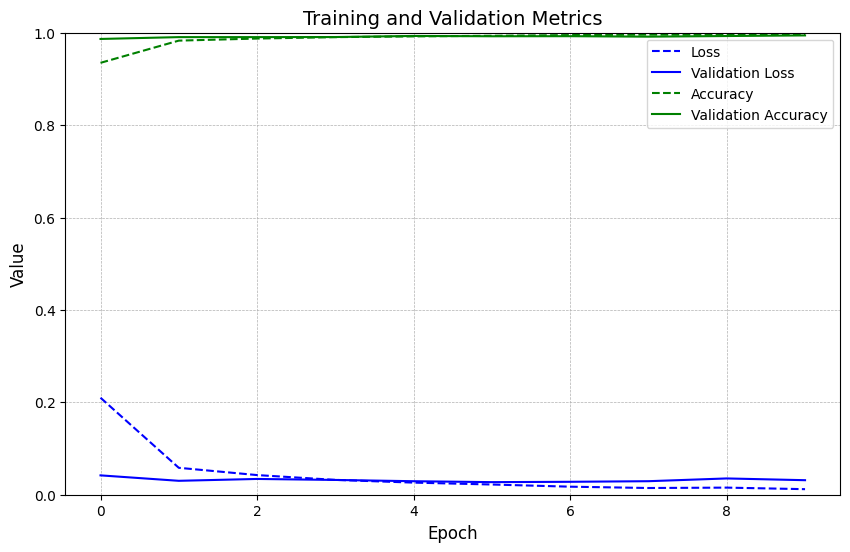

In [11]:
fig = plt.figure(figsize=(10, 6)) 
plt.style.use('default')

ax = fig.add_subplot(1, 1, 1)

ax.plot(history_df['loss'], label='Loss', color='blue', linestyle='--', linewidth=1.5)
ax.plot(history_df['val_loss'], label='Validation Loss', color='blue', linestyle='-', linewidth=1.5)
ax.plot(history_df['accuracy'], label='Accuracy', color='green', linestyle='--', linewidth=1.5)
ax.plot(history_df['val_accuracy'], label='Validation Accuracy', color='green', linestyle='-', linewidth=1.5)

ax.set_title('Training and Validation Metrics', fontsize=14)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Value', fontsize=12)

ax.set_ylim(0, 1.0)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()
plt.show()


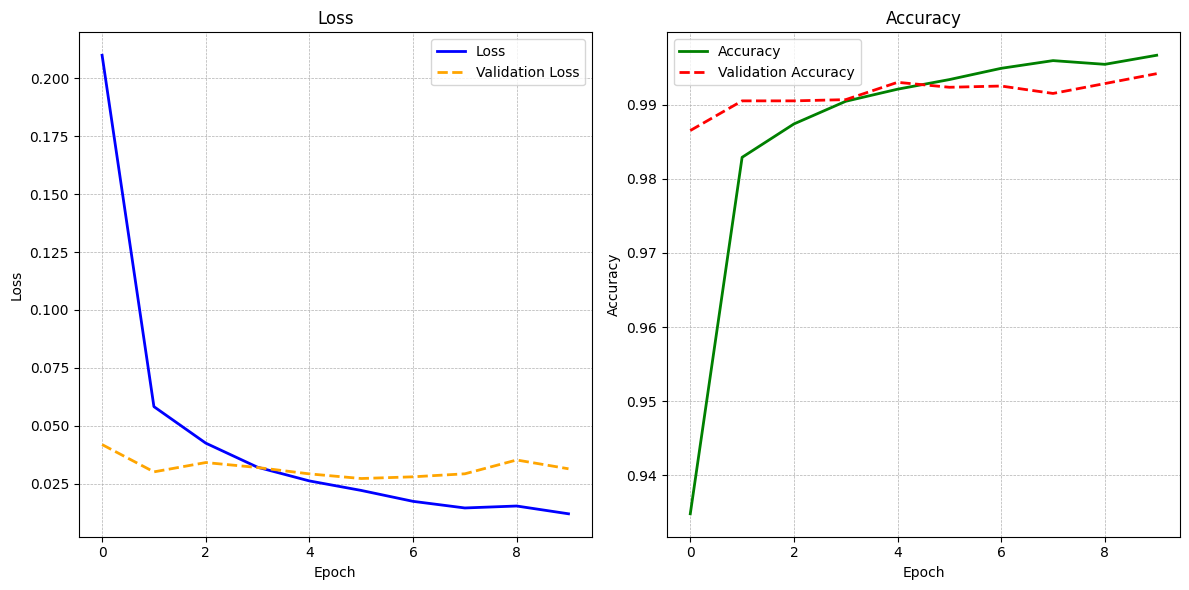

In [12]:
plt.figure(figsize=(12, 6))

plt.style.use('default')

plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Loss', color='blue', linestyle='-', linewidth=2)
plt.plot(history_df['val_loss'], label='Validation Loss', color='orange', linestyle='--', linewidth=2)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['accuracy'], label='Accuracy', color='green', linestyle='-', linewidth=2)
plt.plot(history_df['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--', linewidth=2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

plt.tight_layout()
plt.show()


## 5. Fazer Predições com o Modelo Treinado para Calcular as Métricas

In [13]:
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_labels

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step  


#### EXPLICAÇÕES:

##### **Previsão das Classes no Conjunto de Teste**

Após o treinamento do modelo, o próximo passo é utilizá-lo para fazer previsões no conjunto de teste. Este processo envolve várias etapas:

1. **`y_pred = model_MNIST.predict(test_images)`**:
   - **Objetivo**: Gera as previsões para o conjunto de imagens de teste.
   - **Saída**: `y_pred` será uma matriz onde cada linha representa as probabilidades preditas para cada uma das classes, para cada imagem de teste.

2. **`y_pred_classes = np.argmax(y_pred, axis=1)`**:
   - **Objetivo**: Converte as probabilidades preditas para as classes reais.
   - **`np.argmax`**: Seleciona o índice da classe com a maior probabilidade para cada imagem, produzindo um array `y_pred_classes` que contém a classe prevista (0-9) para cada imagem.

3. **`y_true = np.argmax(test_labels, axis=1)`**:
   - **Objetivo**: Converte as labels verdadeiras de one-hot encoding para as classes reais.
   - **Saída**: `y_true` contém as classes verdadeiras (0-9) para cada imagem no conjunto de teste.

Este procedimento permite a comparação direta entre as classes previstas pelo modelo e as classes verdadeiras, possibilitando a avaliação da performance do modelo em termos de métricas como acurácia, precisão, recall, entre outras.


## 5.1 Calcular Principais Métricas de Avaliação: Acurácia, Precisão, Recall e F1-Score

In [14]:
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

accuracy_percentage = accuracy * 100
precision_percentage = precision * 100
recall_percentage = recall * 100
f1_percentage = f1 * 100

print(f'Acurácia: {accuracy_percentage:.3f}%')
print(f'Precisão: {precision_percentage:.3f}%')
print(f'Recall: {recall_percentage:.3f}%')
print(f'F1-Score: {f1_percentage:.3f}%')

Acurácia: 99.310%
Precisão: 99.311%
Recall: 99.310%
F1-Score: 99.310%


#### EXPLICAÇÕES:


- **Acurácia**: Mede a proporção de previsões corretas sobre o total de previsões realizadas. É uma métrica geral que fornece uma ideia de quão frequentemente o modelo está correto.

- **Precisão**: Mede a proporção de verdadeiros positivos (previsões corretas da classe positiva) sobre o total de positivos previstos. Em outras palavras, entre todas as instâncias que o modelo previu como positivas, quantas realmente são positivas.

- **Recall**: Mede a proporção de verdadeiros positivos sobre o total de positivos reais. Isso avalia a capacidade do modelo de identificar todas as instâncias positivas reais.

- **F1-Score**: É a média harmônica entre precisão e recall. O F1-Score fornece uma única métrica que combina ambas as métricas para avaliar o desempenho do modelo de forma equilibrada, especialmente útil quando há um desequilíbrio entre as classes.

**Obs:** Calcular as métricas e multiplicá-las por 100 para apresentá-las em porcentagem e facilitar a interpretação.


## 5.2 Matriz de Confusão
- A matriz de confusão mostra o número de previsões verdadeiras e falsas para cada classe.

In [15]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print('Matriz de Confusão:')
print(conf_matrix)

Matriz de Confusão:
[[ 978    0    0    0    1    0    0    1    0    0]
 [   0 1130    1    3    0    0    0    1    0    0]
 [   1    0 1025    0    0    0    0    5    1    0]
 [   0    0    0 1008    0    2    0    0    0    0]
 [   0    0    0    0  977    0    1    0    0    4]
 [   0    0    0    7    0  884    1    0    0    0]
 [   4    2    0    0    1    2  948    0    1    0]
 [   0    3    4    0    0    0    0 1018    1    2]
 [   2    0    1    2    0    1    0    0  967    1]
 [   0    0    0    1    4    4    0    2    2  996]]


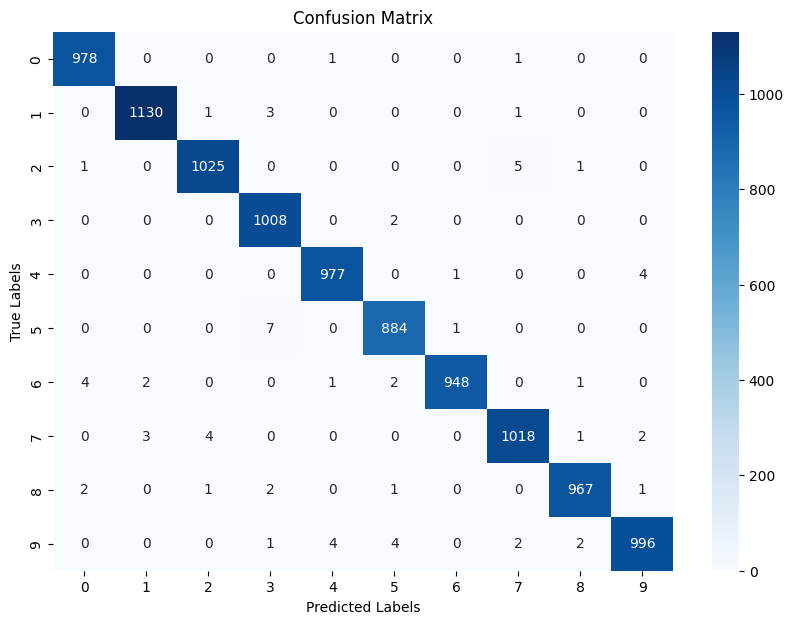

In [16]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## 6. Salvar o Modelo em um Arquivo ".keras"

#### CÓDIGO:

In [17]:
model.save('modelo_MNIST(99.310%).keras')

#### EXPLICAÇÕES:

##### **Salvamento do Modelo em um Arquivo `.keras`**

Após o treinamento do modelo, é importante salvá-lo para reutilização futura sem a necessidade de re-treinamento. A função `model_MNIST.save('modelo_MNIST.keras')` realiza essa tarefa. Aqui está o que acontece com essa operação:

1. **`model_MNIST.save('modelo_MNIST.keras')`**:
   - **Objetivo**: Salva o modelo treinado em um arquivo com a extensão `.keras`.
   - **Arquivo `.keras`**: Este é um formato específico para salvar e carregar modelos treinados usando a biblioteca Keras. Ele inclui a arquitetura do modelo, os pesos treinados e a configuração do compilador (se presente). 
   - **Localização**: O arquivo será salvo no diretório atual do projeto, a menos que um caminho completo seja especificado.
   - **Reutilização**: Após salvar o modelo, você pode carregá-lo posteriormente usando `keras.models.load_model('model_Fashion_MNIST.keras')` para continuar o treinamento, fazer previsões ou avaliar o modelo sem precisar repetir o treinamento.

Este processo facilita a preservação dos resultados do treinamento e a manutenção de consistência em avaliações futuras ou em diferentes sessões de trabalho.
